In [4]:
using Revise
import SuperconductingCavities as SC

using YAXArrays
using DimensionalData

using Logging
using MiniLoggers

import CairoMakie as cm

import FFTW

using Interpolations
using Plots

┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /home/gr400/.julia/packages/YAXArrayBase/Xj43k/ext/NetCDFExt.jl:81


In [5]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

In [6]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

# Implimenting Digitization and Filters (Design Phase)

## Getting Base Signal

In [4]:
envelope = SC.Dynamics.Envelopes.Get_Envelope("Sine_Squared_Ramp", Dict{Any, Any}("ramp_time"  => 10, "pulse_time" => 100))

ν = Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["freq_d"]+Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["shift"]
ε = Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["epsilon"]

sig_func = SC.Dynamics.Get_Drive_Coef(ν, ε, envelope=envelope, return_ℂ=true)

(::SuperconductingCavities.Dynamics.var"#drive_coef#3"{Bool, SuperconductingCavities.Dynamics.var"#drive_coef#2#4"{SuperconductingCavities.Dynamics.Envelopes.var"#envelope#6"{String, Dict{Symbol, Any}}, Float64, Float64}}) (generic function with 1 method)

In [58]:
function DigitizeEnvelope(t, envelope; step_length = 2.3)
    N = floor(t/step_length)
    return envelope(N*step_length)
end

envelope_d(t) = DigitizeEnvelope(t, envelope)
sig_func_d = SC.Dynamics.Get_Drive_Coef(ν, ε, envelope=envelope_d)

(::SuperconductingCavities.Dynamics.var"#drive_coef#3"{Bool, SuperconductingCavities.Dynamics.var"#drive_coef#2#4"{typeof(envelope_d), Float64, Float64}}) (generic function with 1 method)

In [34]:
fs = 1e2
times = collect(0:1/fs:100)
sig = sig_func.(times);
ev = envelope.(times);
ev_d = DigitizeEnvelope.(times, envelope);
sig_d = sig_func_d.(times);

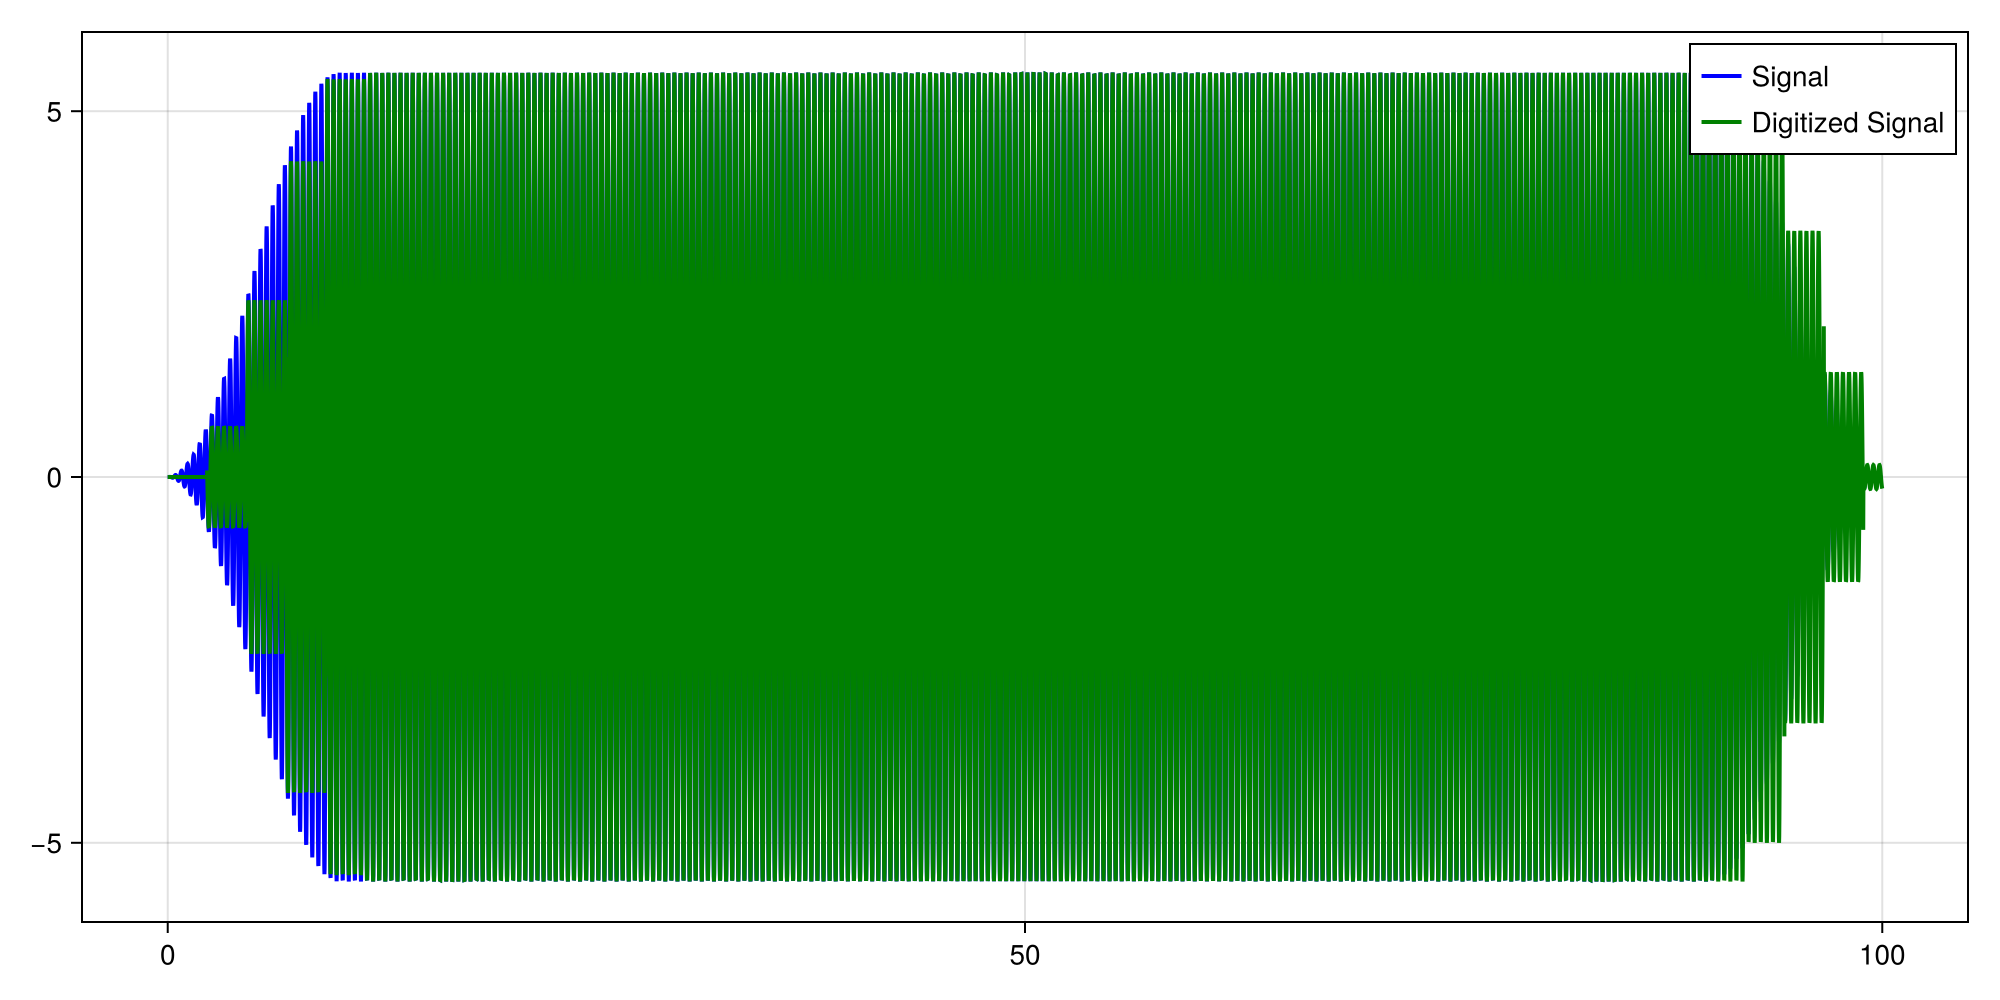

In [40]:
f = cm.Figure(size=(1000, 500))
ax = cm.Axis(f[1, 1])

plot_every = 1
x = times[1:plot_every:end]
y = imag.(sig[1:plot_every:end])
cm.lines!(ax, x, y, color=:blue,linewidth=2, label = "Signal")

x = times[1:plot_every:end]
y = imag.(sig_d[1:plot_every:end])
cm.lines!(ax, x, y, color=:green,linewidth=2, label = "Digitized Signal")
cm.axislegend(ax, position = :rt)
f

## Filtering

### Getting Fourier Transform

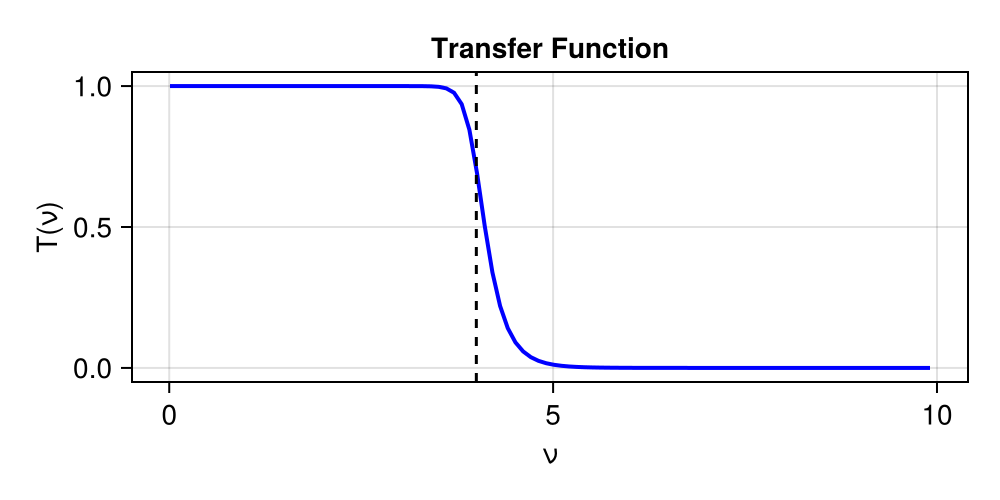

In [52]:
fft = FFTW.fft(sig);
fft_d = FFTW.fft(sig_d);

freqs = collect(1:1:length(fft))*fs/length(fft);

ν_cutoff = 4
order = 20
T(ν) = (1/(sqrt(1 + ((ν)/(ν_cutoff))^(2*order))))

Y = fft.*T.(freqs)
Y_d = fft_d.*T.(freqs)

ifft = (FFTW.ifft(Y))
ifft_d = (FFTW.ifft(Y_d)); 

f = cm.Figure(size=(500, 250))
ax = cm.Axis(f[1, 1], xlabel="ν", ylabel="T(ν)", title="Transfer Function")

plot_every = 10
plot_before = 1000# length(freqs)
x = freqs[1:plot_every:plot_before]
y = abs.(T.(freqs))[1:plot_every:plot_before]
cm.lines!(ax, x, y, color=:blue,linewidth=2, label = "Transfer Function")
cm.vlines!(ax, [ν_cutoff], color=:black, linestyle = :dash, label = "Cutoff Frequency")
f

In [46]:
T(ν_cutoff)

0.7071067811865475

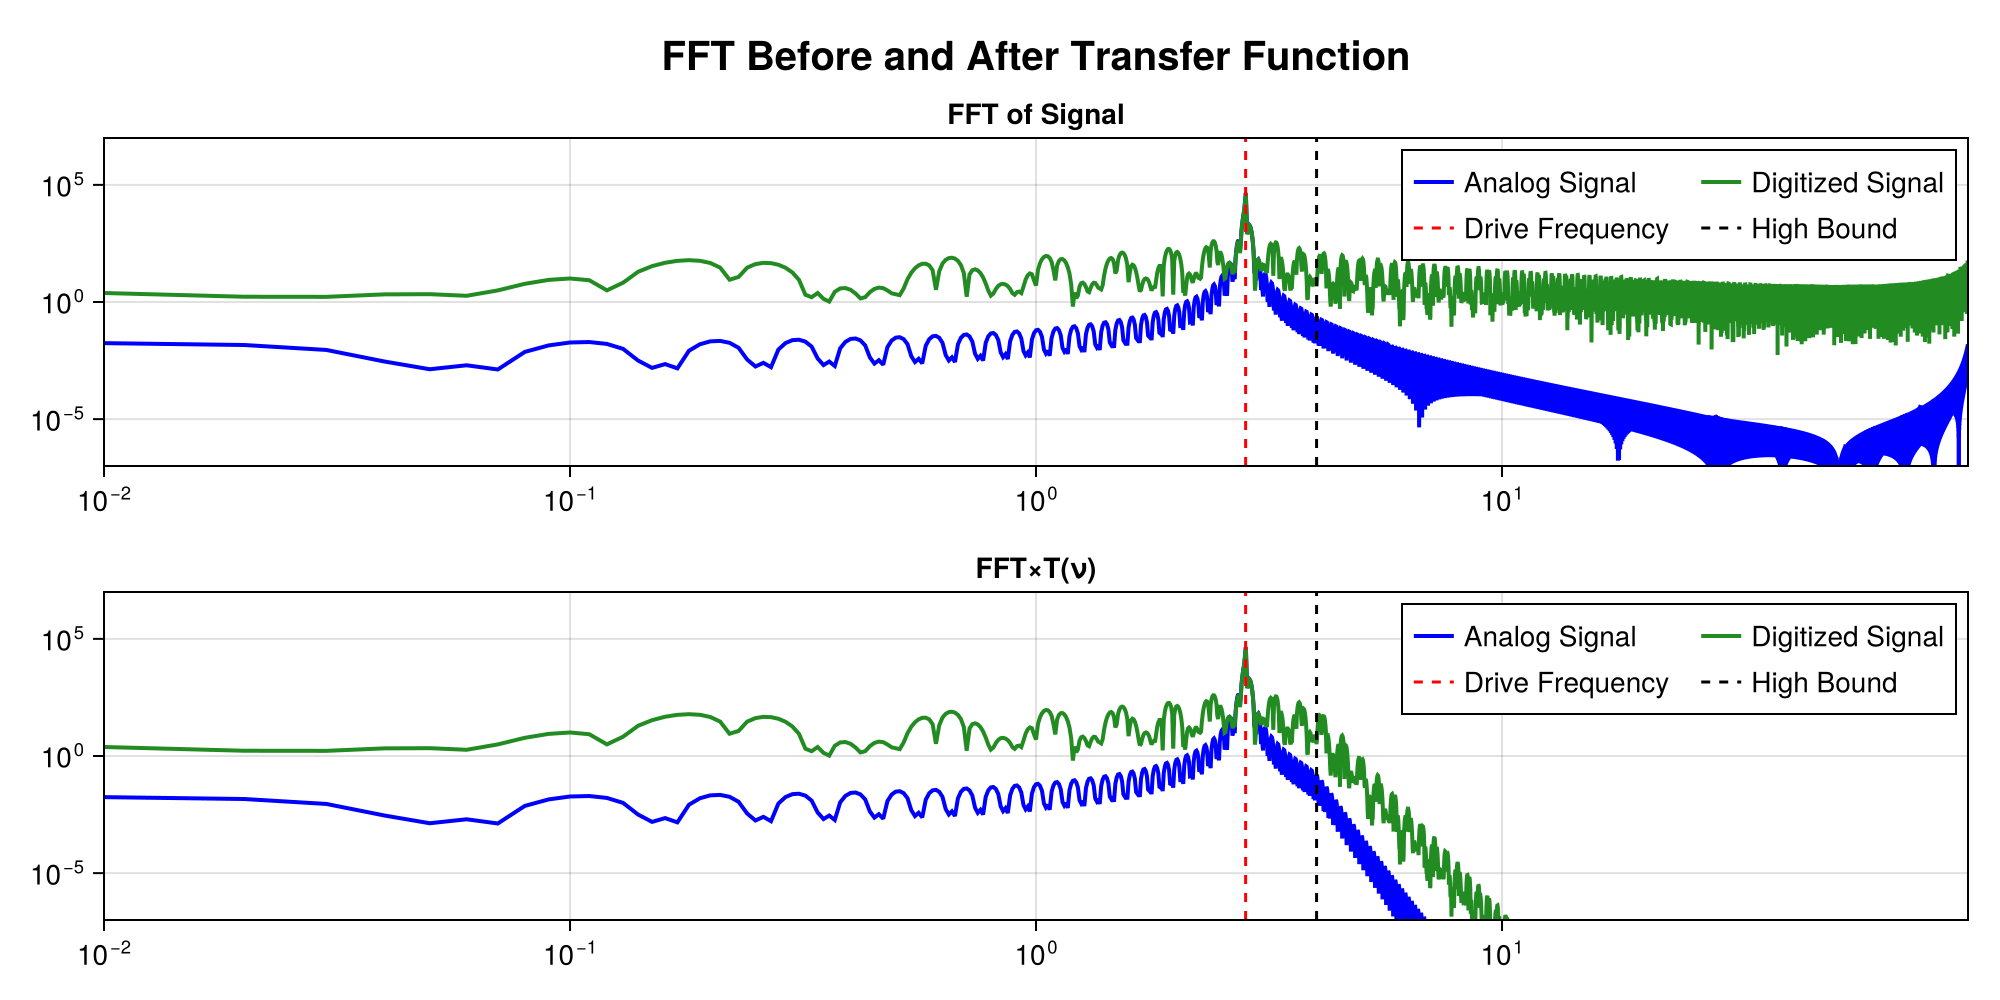

In [55]:
plot_every = 1
plot_before = length(fft)
x = collect(0:1:length(fft))[1:plot_every:plot_before]*fs/length(fft)

fig_size = (1000, 500)
lims = ((x[2], x[end]), (1e-7, 1e7))

f = cm.Figure(size=fig_size)
ax = cm.Axis(f[1, 1], xscale = cm.log10, yscale = cm.log10, limits = lims, title="FFT of Signal")

y = abs.(fft[1:plot_every:plot_before])
cm.lines!(ax, x, y, color=:blue,linewidth=2, label = "Analog Signal")


y = abs.(fft_d[1:plot_every:plot_before])
cm.lines!(ax, x, y, color=:forestgreen,linewidth=2, label = "Digitized Signal")

cm.vlines!(ax, [abs(ν)], color=:red, label = "Drive Frequency", linestyle = :dash)
#cm.vlines!(ax, [1], color = :black, label = "Low Bound", linestyle = :dash)
cm.vlines!(ax, [ν_cutoff], color = :black, label = "High Bound", linestyle = :dash)
cm.axislegend(ax, position = :rt, nbanks = 2)

ax2 = cm.Axis(f[2, 1], xscale = cm.log10, yscale = cm.log10, limits = lims, title = "FFT×T(ν)")

y = abs.(Y[1:plot_every:plot_before])
cm.lines!(ax2, x, y, color=:blue,linewidth=2, label = "Analog Signal")


y = abs.(Y_d[1:plot_every:plot_before])
cm.lines!(ax2, x, y, color=:forestgreen,linewidth=2, label = "Digitized Signal")

cm.vlines!(ax2, [abs(ν)], color=:red, label = "Drive Frequency", linestyle = :dash)
#cm.vlines!(ax2, [1], color = :black, label = "Low Bound", linestyle = :dash)
cm.vlines!(ax2, [ν_cutoff], color = :black, label = "High Bound", linestyle = :dash)
cm.axislegend(ax2, position = :rt, nbanks = 2)

cm.Label(f[1,1:1, cm.Top()], "FFT Before and After Transfer Function", valign = :bottom, padding = (0,0,30,0), font =:bold, fontsize = 20)

f

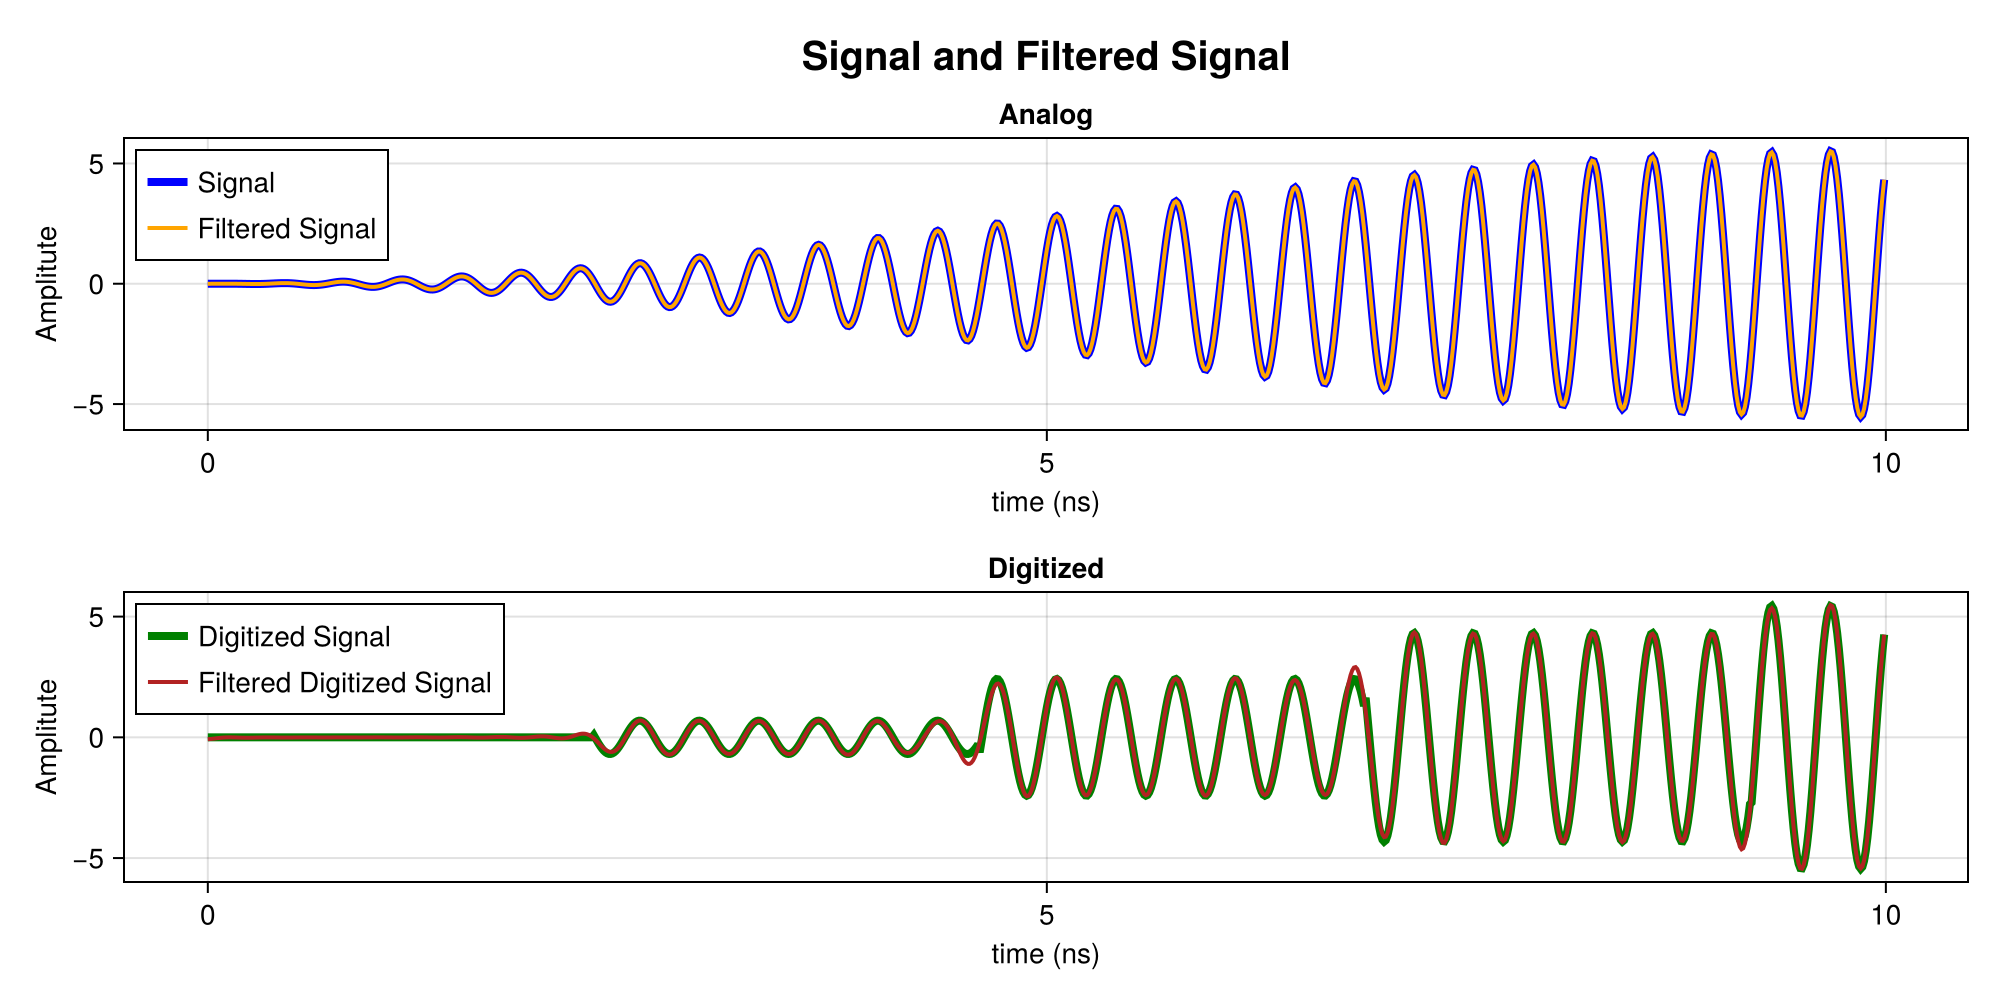

In [56]:
f = cm.Figure(size=(1000, 500))
ax = cm.Axis(f[1, 1], title="Analog", xlabel = "time (ns)", ylabel = "Amplitute")
plot_every = 1
plot_end = 1000

x = times[1:plot_every:plot_end]
y = imag.(sig[1:plot_every:plot_end])
cm.lines!(ax, x, y, color=:blue,linewidth=4, label = "Signal")

x = times[1:plot_every:plot_end]
y = imag.(ifft[1:plot_every:plot_end])
cm.lines!(ax, x, y, color=:orange,linewidth=2, label = "Filtered Signal")

cm.axislegend(ax, position = :lt)

ax2 = cm.Axis(f[2, 1], title = "Digitized", xlabel = "time (ns)", ylabel = "Amplitute")

x = times[1:plot_every:plot_end]
y = imag.(sig_d[1:plot_every:plot_end])
cm.lines!(ax2, x, y, color=:green,linewidth=4, label = "Digitized Signal")

x = times[1:plot_every:plot_end]
y = imag.(ifft_d[1:plot_every:plot_end])
cm.lines!(ax2, x, y, color=:firebrick,linewidth=2, label = "Filtered Digitized Signal")

cm.axislegend(ax2, position = :lt)

cm.Label(f[1,1:1, cm.Top()], "Signal and Filtered Signal", valign = :bottom, padding = (0,0,30,0), font =:bold, fontsize = 20)
f

In [22]:
#new_drive = linear_interpolation(times, ifft)

In [73]:
res = SC.Dynamics.Get_Low_Pass_Filtered_Drive_Coef(sig_func_d, 100);

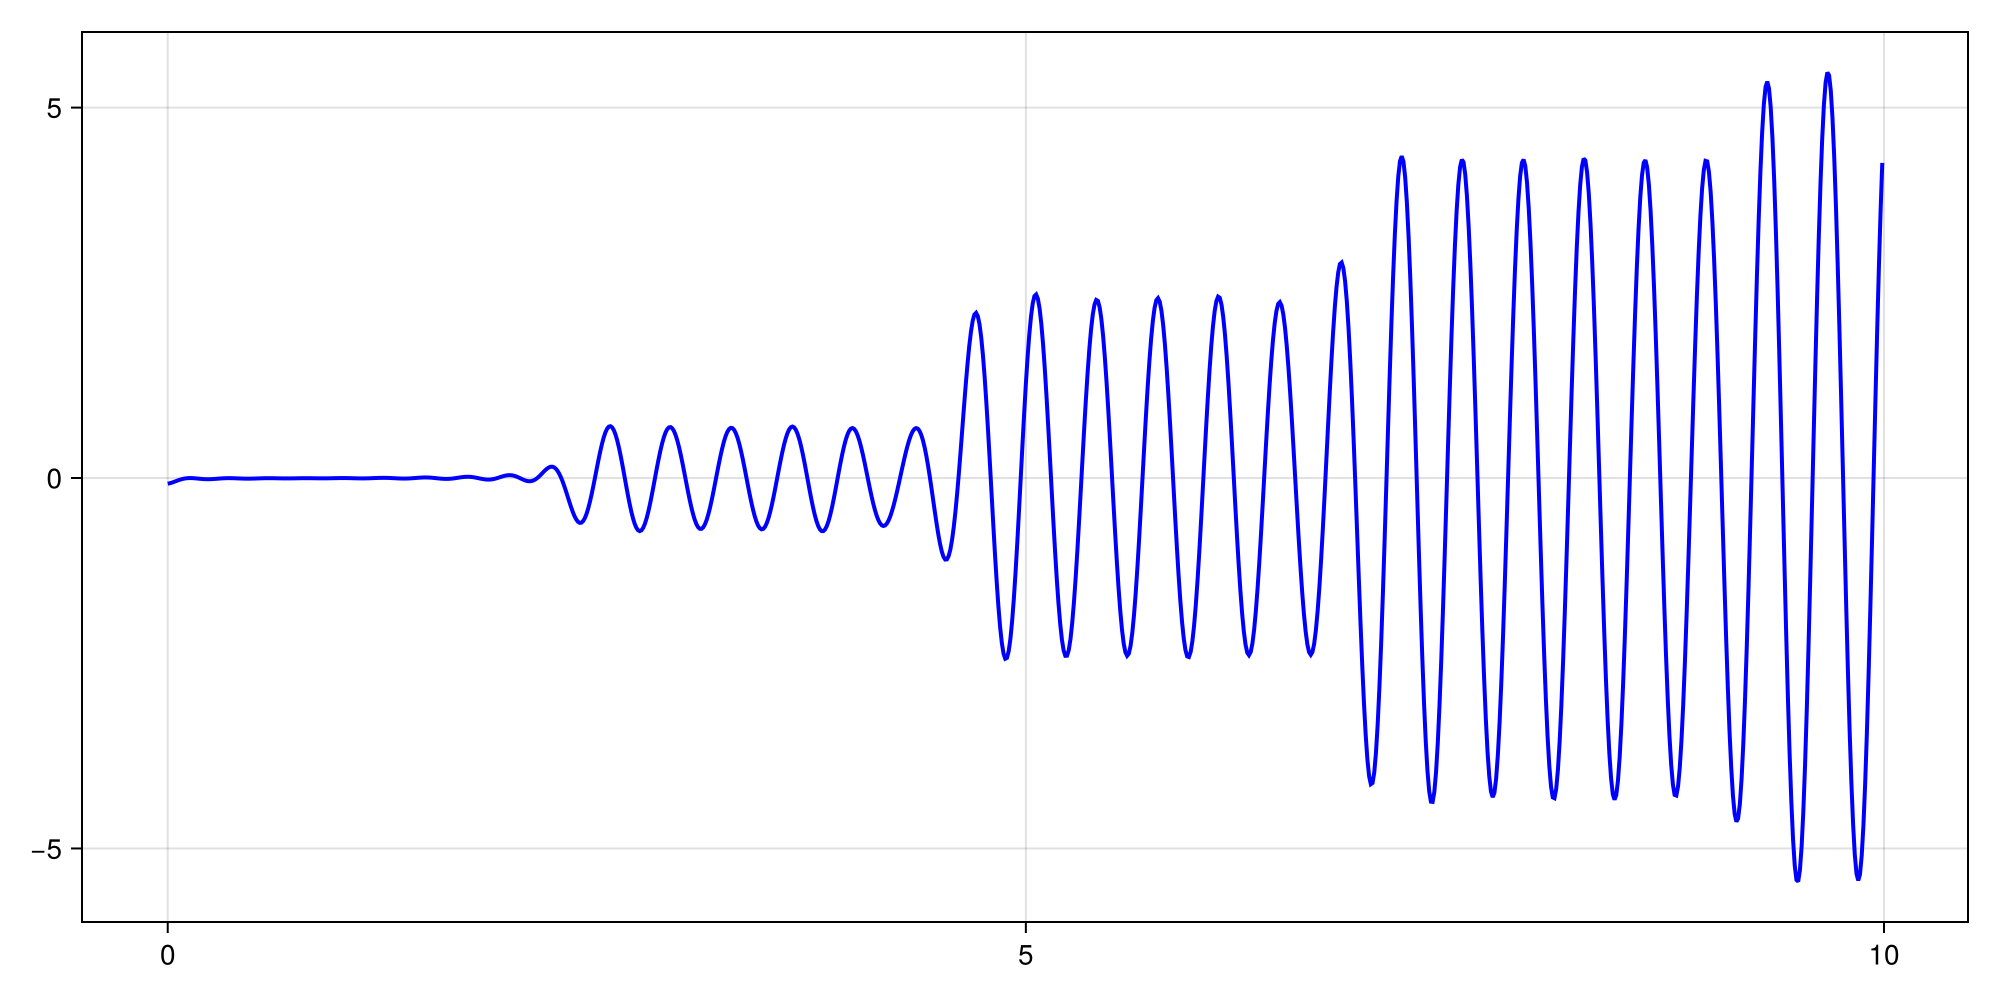

In [74]:
f = cm.Figure(size=(1000, 500))
ax = cm.Axis(f[1,1])

x = times[1:1000]
y = res.(x)

cm.lines!(ax, x, y, color=:blue,linewidth=2, label = "Filtered Signal")
f

# Testing the package

Lets digitize the f0g1 sideband and filter!

In [7]:
pulse = copy(Mode3.Stuff["op_drive_params"]["sb_f_0_Main"])

Dict{String, Any} with 6 entries:
  "pulse_time"    => 177.8
  "Envelope Args" => Dict{String, Any}("pulse_time"=>177.8, "ramp_time"=>10)
  "epsilon"       => 0.88
  "Envelope"      => "Sine_Squared_Ramp"
  "shift"         => 0.0530359
  "freq_d"        => -2.87015

In [28]:
ε = pulse["epsilon"]
ν = pulse["freq_d"] + pulse["shift"]

envelope = SC.Dynamics.Envelopes.Get_Envelope(pulse["Envelope"], pulse["Envelope Args"], digitize = true)


base_drive_coef = SC.Dynamics.Get_Drive_Coef(ν, ε, envelope=envelope);

drive_coef = SC.Dynamics.Get_Low_Pass_Filtered_Drive_Coef(base_drive_coef, pulse["pulse_time"], poles = 20, freq_cutoff = 3.2, fs = 1e2);

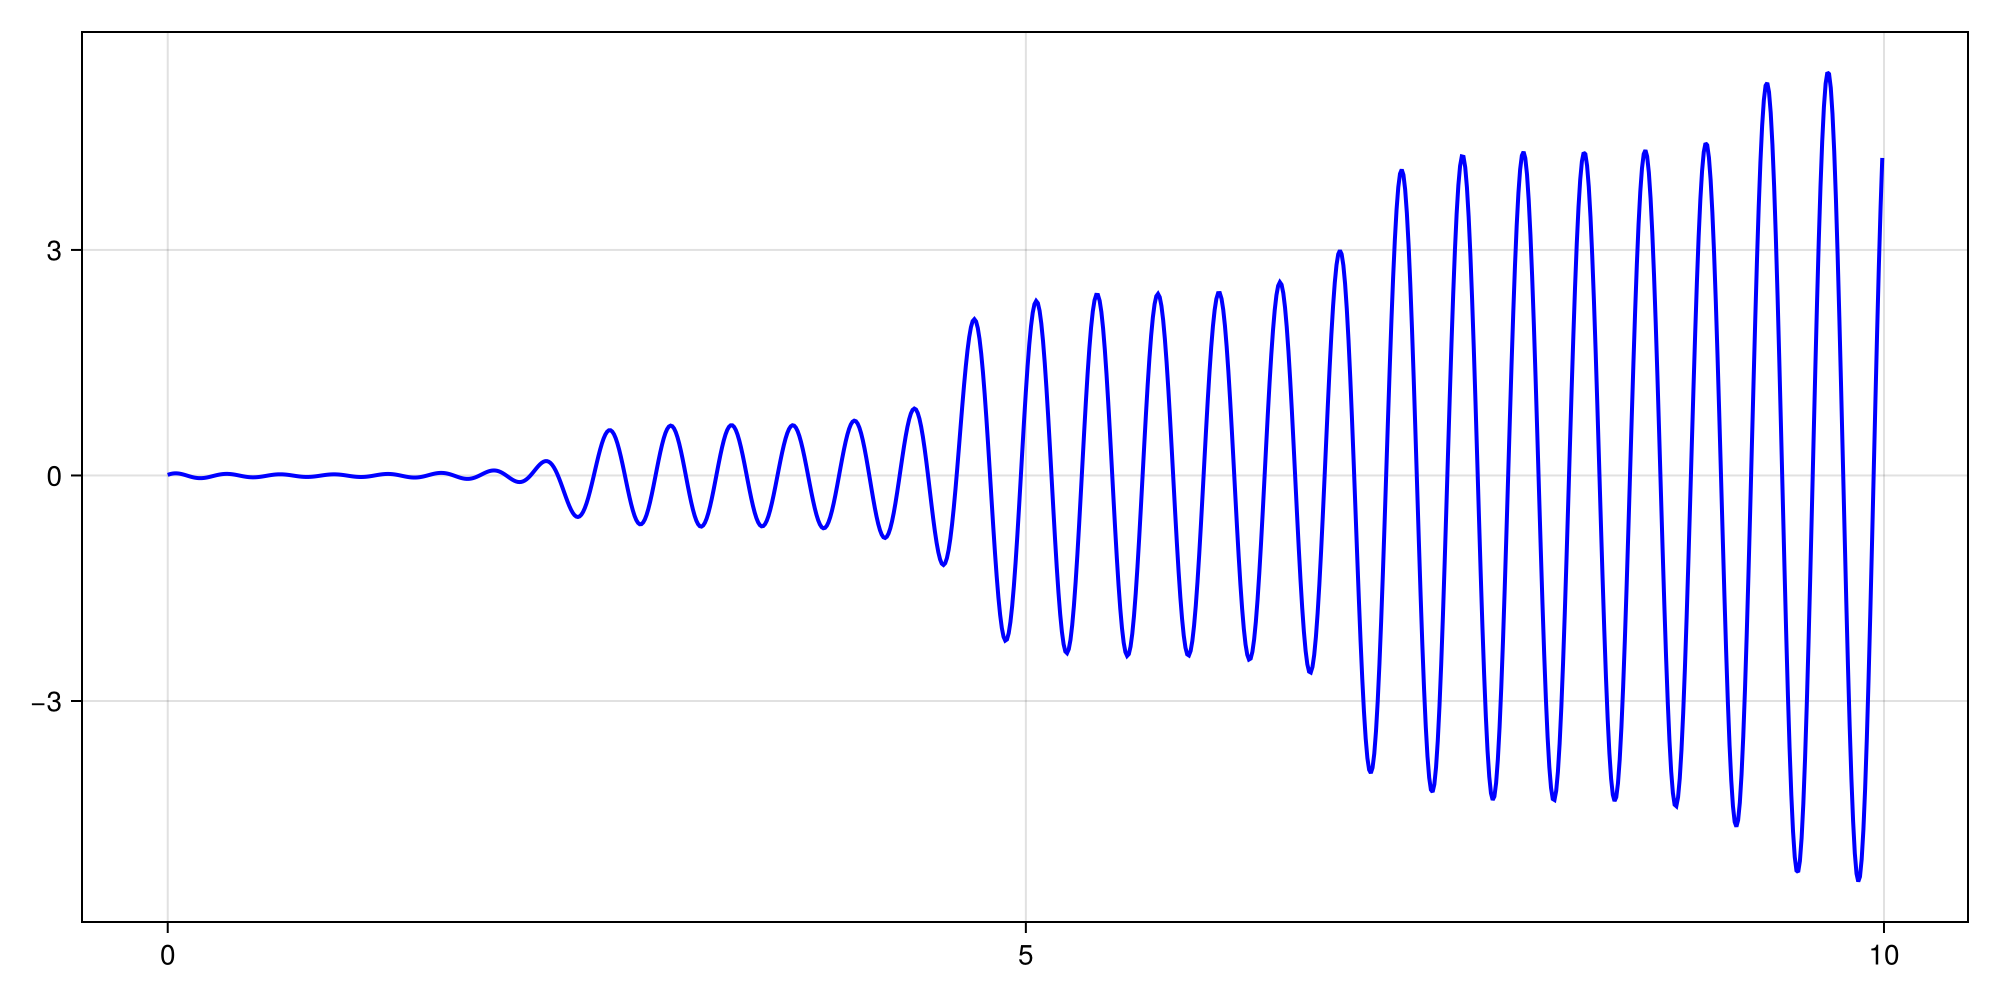

In [14]:
x = collect(0:1e-2:pulse["pulse_time"])[1:1000]
y = drive_coef.(x)

f = cm.Figure(size=(1000, 500))
ax = cm.Axis(f[1,1])
cm.lines!(ax, x, y, color=:blue,linewidth=2, label = "Filtered Signal")
f

## Calibrating a pulse

In [111]:
ψ1 = Mode3.dressed_states[(2,0)]
ψ2 = Mode3.dressed_states[(0,1)]

ε = 0.78
freq_d = Mode3.Stuff["op_drive_params"]["sb_f_0_Main"]["freq_d"]
shift = 0.042200385158

rt = 9
t_range = [180, 210]
envelope = "Sine_Squared_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" => rt)
filter_params = Dict{Any, Any}("poles" => 20)

res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ε, freq_d, shift, t_range, envelope, envelope_args, samples_per_level = 5, digitize = true, step_length = 2.3, filter_params = filter_params)

[2024-10-28 22:29:01] Info: On Level 1
[2024-10-28 22:29:01] Info: On Step 1: t = 180.0
[2024-10-28 22:29:01] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-10-28 22:29:04] Info: Time Evolution Complete
[2024-10-28 22:29:04] Info: Done with Level_1_step_1
[2024-10-28 22:29:04] Info: Accurace: 0.9702804484872618
[2024-10-28 22:29:04] Info: ------------------------------------------------------------------------------
[2024-10-28 22:29:04] Info: On Step 2: t = 187.5
[2024-10-28 22:29:04] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-10-28 22:29:07] Info: Time Evolution Complete
[2024-10-28 22:29:07] Info: Done with Level_1_step_2
[2024-10-28 22:29:07] Info: Accurace: 0.9817872357256534
[2024-10-28 22:29:07] Info: ------------------------------------------------------------------------------
[2024-10-28 22:29:07] Info: O

Dict{Any, Any} with 10 entries:
  "pulse_time"    => 196.875
  "digitize"      => true
  "freq_d"        => -2.87015
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>196.875, "ramp_time"=>9)
  "epsilon"       => 0.78
  "filter_params" => Dict{Any, Any}("poles"=>20)
  "Envelope"      => "Sine_Squared_Ramp"
  "shift"         => 0.0422004
  "accuracy"      => 0.988901
  "step_length"   => 2.3

In [106]:
pulse = copy(res)
#pulse = copy(Mode3.Stuff["op_drive_params"]["sb_f_0_Main"])
ψ = Mode3.dressed_states[(2,0)]
T = abs(1/(pulse["freq_d"]+pulse["shift"]))
times = vcat(collect(0:T:pulse["pulse_time"]), [pulse["pulse_time"]])
run_res = SC.Dynamics.RunSingleOperator(Mode3, ψ, pulse, to_return = "All", tspan = times)

[2024-10-28 22:21:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-10-28 22:21:53] Info: Time Evolution Complete
[2024-10-28 22:21:53] Info: Done with DEFAULT


Solution of time evolution
(return code: Success)
--------------------------
num_states = 558
num_expect = 0
ODE alg.: OrdinaryDiffEqVerner.Vern9{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false), true)
abstol = 1.0e-6
reltol = 1.0e-6


In [108]:
filter_params

Dict{Any, Any} with 1 entry:
  "poles" => 20

Dict{Symbol, Int64} with 1 entry:
  :poles => 20

In [98]:
proj_dict = SC.Utils.Get_Projection_Ops(Mode3.dressed_states);
EVs = SC.Utils.Get_EVs(run_res.states, proj_dict);

[2024-10-28 22:15:39] Info: Making Plot


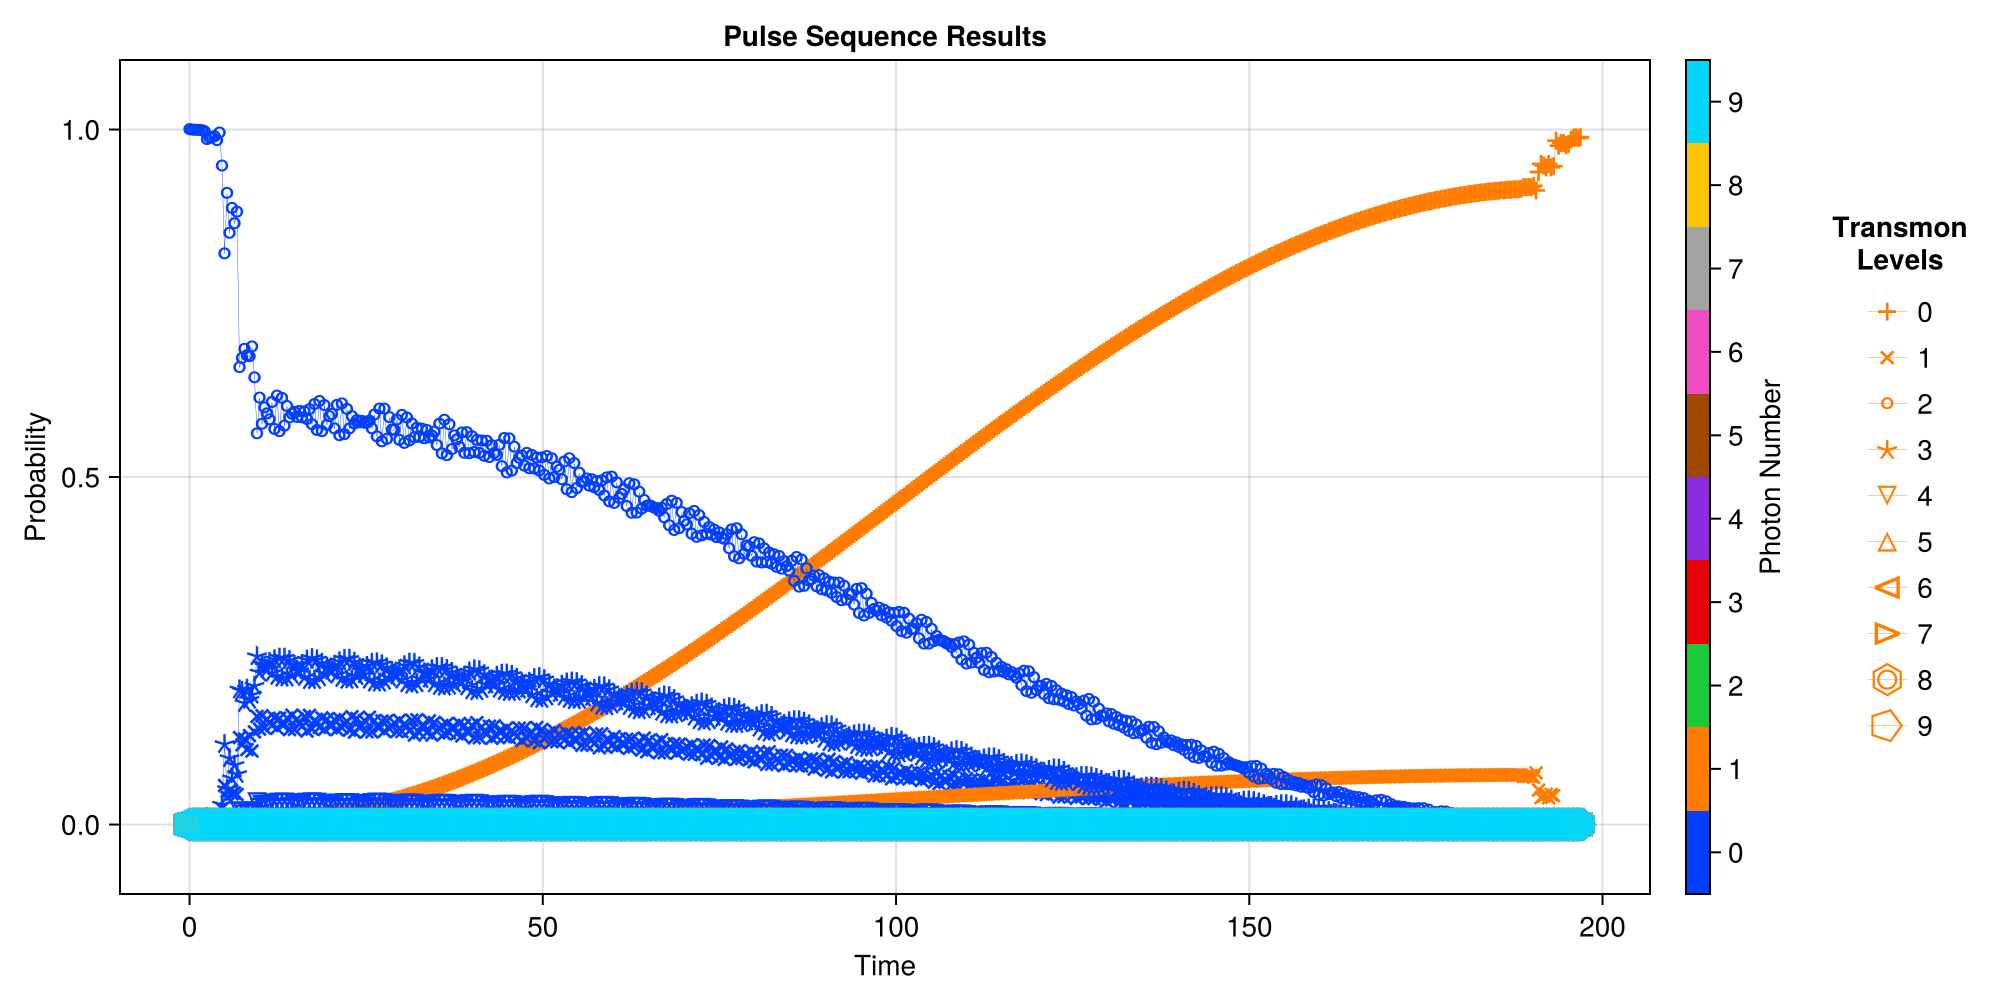

CairoMakie.Screen{IMAGE}


In [99]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, run_res.times, EVs)

In [100]:
envelope = SC.Dynamics.Envelopes.Get_Envelope(pulse["Envelope"], pulse["Envelope Args"], digitize = true)

(::SuperconductingCavities.Dynamics.Envelopes.var"#digitized_envelope#7"{Float64, SuperconductingCavities.Dynamics.Envelopes.var"#envelope#9"{String, Dict{Symbol, Any}}}) (generic function with 1 method)

In [101]:
list_of_params = []
for t in run_res.times
    ε = pulse["epsilon"]*envelope(t)
    dict_to_apppend = Dict{Any, Any}("ε" => ε, "ν"=>pulse["freq_d"]+pulse["shift"])
    push!(list_of_params, dict_to_apppend)
end

floq_sweep_res = SC.Dynamics.Floquet_t0_Sweep(Mode3, list_of_params, states_to_track = Mode3.dressed_states);

[2024-10-28 22:15:43] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


[2024-10-28 22:15:48] Info: Done With Floquet Sweep
[2024-10-28 22:15:48] Info: Tracking State


Progress:  17%|███████▏                                 |  ETA: 0:00:06

[2024-10-28 22:15:49] Info: Running the necessary time evolutions


In [102]:
floq_proj = Dict{Any, Any}()

for state in keys(Mode3.dressed_states)
    floq_proj[state] = []
    for i in 1:length(run_res.times)
        ψ=floq_sweep_res[State = At(string(state)), Step = At(i)]["ψ"]
        push!(floq_proj[state], abs(ψ'*run_res.states[i])^2)
    end
end

[2024-10-28 22:16:01] Info: Making Plot


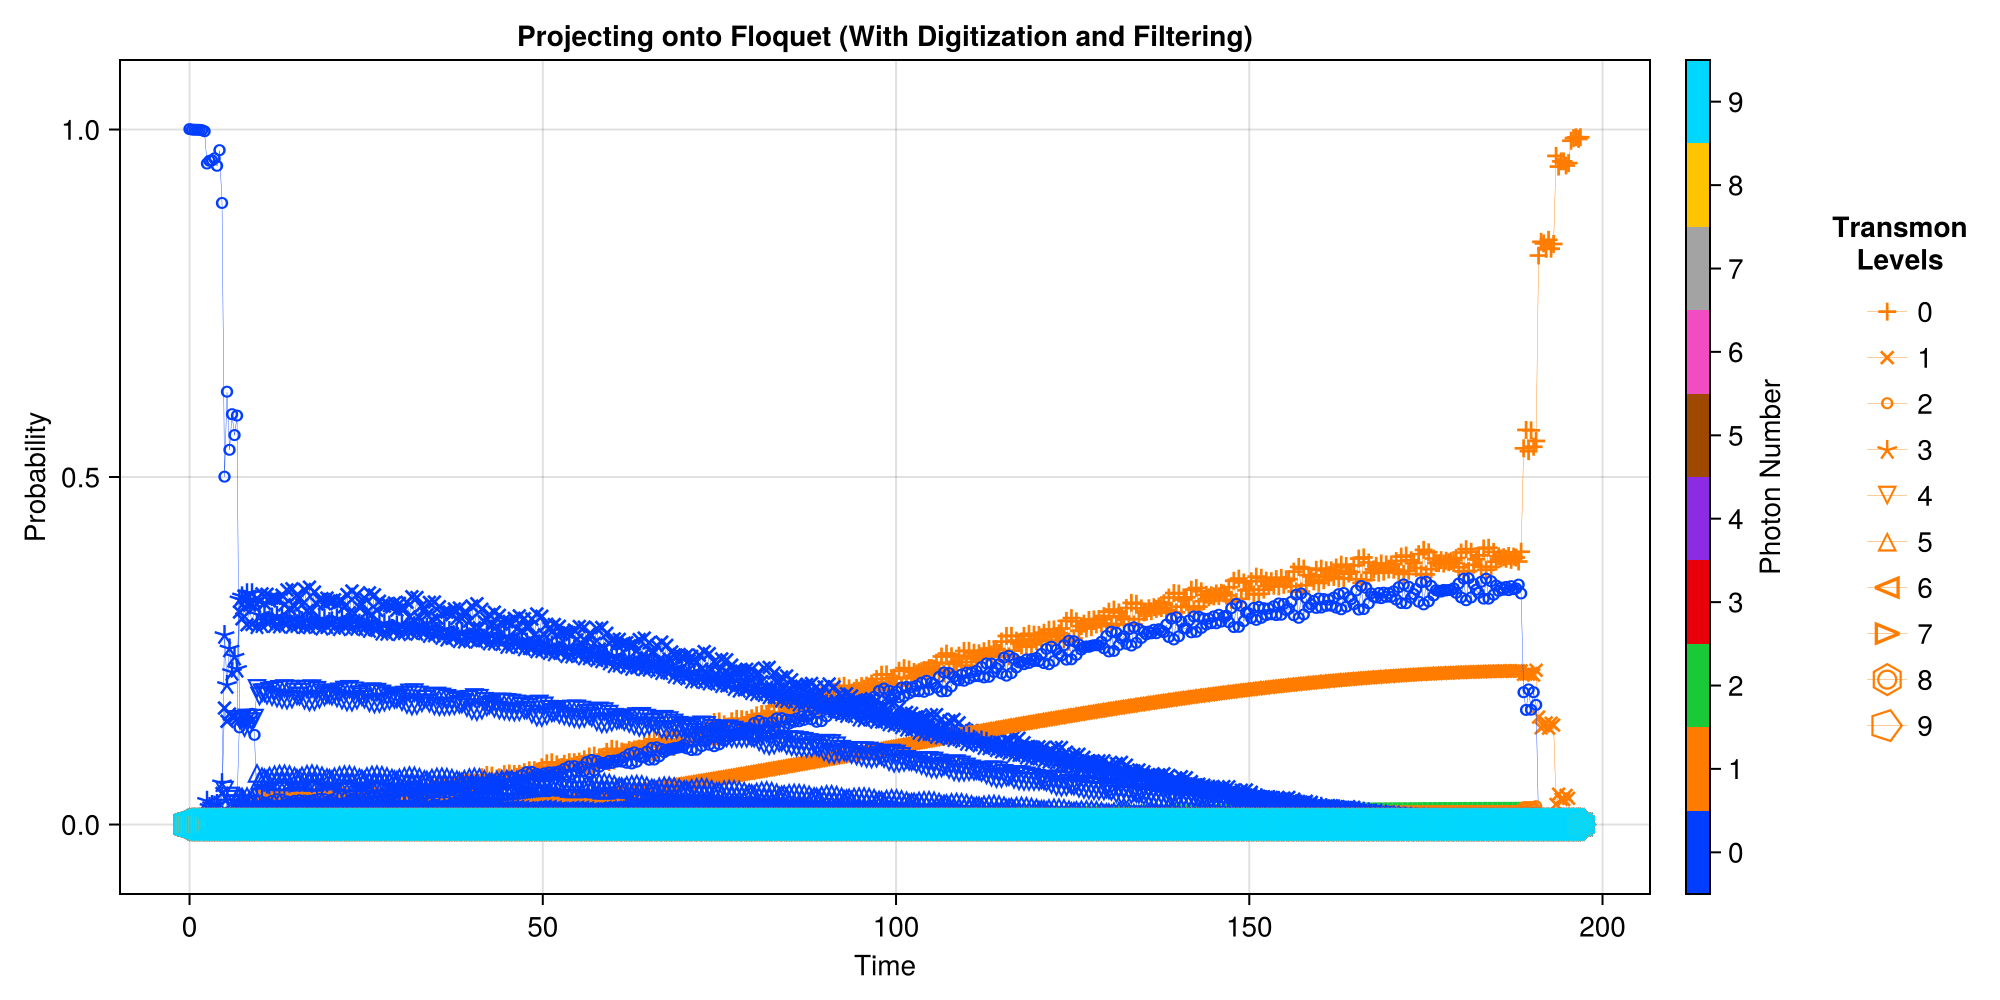

CairoMakie.Screen{IMAGE}


In [104]:
axis_kwargs = Dict{Any, Any}("title" => "Projecting onto Floquet (With Digitization and Filtering)")
SC.Dynamics.PlotSingleModeEvolution(Mode3, run_res.times, floq_proj, axis_kwargs = axis_kwargs)